# Introduction to neuroimaging data with Python

In this tutorial we will learn how to load, plot, and manipulate neuroimaging data in Python

Written by Luke Chang

## Nibabel

Neuroimaging data is often stored in the format of nifti files `.nii` which can also be compressed using gzip `.nii.gz`.  These files store both 3D and 4D data and also contain structured metadata in the image **header**.

There is an very nice tool to access nifti data stored on your file system in python called [nibabel](http://nipy.org/nibabel/).  If you don't already have nibabel installed on your computer it is easy via `pip`. First, tell the jupyter cell that you would like to access the unix system outside of the notebook and then install nibabel using pip. You only need to run this once (unless you would like to update the version).

In [1]:
!pip install nibabel

nibabel objects can be initialized by simply pointing to a nifti file even if it is compressed through gzip.  First, we will import the nibabel module as `nib` (short and sweet so that we don't have to type so much when using the tool).  I'm also including a path to where the data file is located so that I don't have to constantly type this.  It is easy to change this on your own computer.

We will be loading an anatomical image from subject S01 from the open localizer [dataset](http://brainomics.cea.fr/localizer/).  See this [paper](https://bmcneurosci.biomedcentral.com/articles/10.1186/1471-2202-8-91) for more information about this dataset.

In [6]:
import os
import nibabel as nib

base_dir = '/dartfs/rc/lab/P/Psych60/'
!pwd


/Users/tom/baic/book/content/labs/lab-Image


In [23]:
# data = nib.load(os.path.join(base_dir, 'data','brainomics_data','S01','normalized_T1_anat_defaced.nii.gz'))
data = nib.load()

In [ ]:
data.get_data()

If we want to get more help on how to work with the nibabel data object we can either consult the [documentation](https://nipy.org/nibabel/tutorials.html#tutorials) or add a `?`.

In [6]:
data?

The imaging data is stored in either a 3D or 4D numpy array. Just like numpy, it is easy to get the dimensions of the data using `shape`

In [7]:
data.shape

(157, 189, 136)

We can also directly access the data and plot a single slice using standard matplotlib functions.

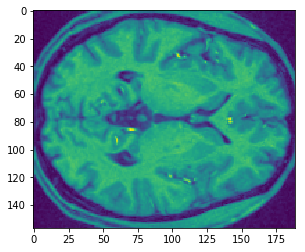

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.imshow(data.get_data()[:,:,50])

Try slicing different dimensions (x,y,z) yourself to get a feel for how the data is represented in this anatomical image.

We can also access data from the image header. Let's assign the header of an image to a variable and print it to view it's contents.

In [9]:
header = data.header
print(header)      

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 157 189 136   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  0.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FreeSurfer Mar  1 2013'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 78.0
qoffset_y       : -112.0
qoffset_z       : -50.0
srow_x          : 

Some of the important information in the header is information about the orientation of the image in space. This can be represented as the affine matrix.

In [10]:
data.affine

array([[  -1.,    0.,    0.,   78.],
       [   0.,    1.,    0., -112.],
       [   0.,    0.,    1.,  -50.],
       [   0.,    0.,    0.,    1.]])

The affine matrix is a way to transform images between spaces.

Here is a short tutorial on affine transformations from the nibabel [documentation](https://nipy.org/nibabel/coordinate_systems.html).  

Here is another nice [tutorial](https://nilearn.github.io/auto_examples/04_manipulating_images/plot_affine_transformation.html#sphx-glr-auto-examples-04-manipulating-images-plot-affine-transformation-py) from nilearn in 2D space.

We have voxel coordinates (in voxel space).  We want to get scanner RAS+
coordinates corresponding to the voxel coordinates.  We need a *coordinate
transform* to take us from voxel coordinates to scanner RAS+ coordinates.

In general, we have some voxel space coordinate $(i, j, k)$, and we want to
generate the reference space coordinate $(x, y, z)$.

Imagine we had solved this, and we had a coordinate transform function $f$
that accepts a voxel coordinate and returns a coordinate in the reference
space:

$(x, y, z) = f(i, j, k)$

$f$ accepts a coordinate in the *input* space and returns a coordinate in the
*output* space.  In our case the input space is voxel space and the output
space is scanner RAS+.

In theory $f$ could be a complicated non-linear function, but in practice, we
know that the scanner collects data on a regular grid.  This means that the
relationship between $(i, j, k)$ and $(x, y, z)$ is linear (actually
*affine*), and can be encoded with linear (actually affine) transformations
comprising translations, rotations and zooms [wikipedia linear transform](https://en.wikipedia.org/wiki/Linear_map)

Scaling (zooming) in three dimensions can be represented by a diagonal 3 by 3
matrix.  Here's how to zoom the first dimension by $p$, the second by $q$ and
the third by $r$ units:

$$
\begin{bmatrix}
x\\
y\\
z
\end{bmatrix} 
\quad
=
\quad
\begin{bmatrix}
p & i\\
q & j\\
r & k
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
p & 0 & 0 \\
0 & q & 0 \\
0 & 0 & r
\end{bmatrix}
\quad
\begin{bmatrix}
i\\
j\\
k
\end{bmatrix}
$$

A rotation in three dimensions can be represented as a 3 by 3 *rotation
matrix* [wikipedia rotation matrix](https://en.wikipedia.org/wiki/Rotation_matrix).  For example, here is a rotation by
$\theta$ radians around the third array axis:

$$
\begin{bmatrix}
x \\
y \\
z
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
\cos(\theta) &  -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
\quad
\begin{bmatrix}
i \\
j \\
k
\end{bmatrix}
$$

This is a rotation by $\phi$ radians around the second array axis:

$$
\begin{bmatrix}
x \\
y \\
z \\
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
\cos(\phi) & 0 & \sin(\phi) \\
0 & 1 & 0 \\
-\sin(\phi) & 0 & \cos(\phi) \\
\end{bmatrix}
\quad
\begin{bmatrix}
i \\
j \\
k 
\end{bmatrix}
$$

A rotation of $\gamma$ radians around the first array axis:

$$
\begin{bmatrix}
x\\
y\\
z
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos(\gamma) & -\sin(\gamma) \\
0 & \sin(\gamma) & \cos(\gamma) \\
\end{bmatrix}
\quad
\begin{bmatrix}
i \\
j \\
k
\end{bmatrix}
$$

Zoom and rotation matrices can be combined by matrix multiplication.

Here's a scaling of $p, q, r$ units followed by a rotation of $\theta$ radians
around the third axis followed by a rotation of $\phi$ radians around the
second axis:

$$
\begin{bmatrix}
x \\
y \\
z
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
\cos(\phi) & 0 & \sin(\phi) \\
0 & 1 & 0 \\
-\sin(\phi) & 0 & \cos(\phi) \\
\end{bmatrix}
\quad
\begin{bmatrix}
\cos(\theta) &  -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
\quad
\begin{bmatrix}
p & 0 & 0 \\
0 & q & 0 \\
0 & 0 & r \\
\end{bmatrix}
\quad
\begin{bmatrix}
i\\
j\\
k\\
\end{bmatrix}
$$

This can also be written:


$$
M
\quad
=
\quad
\begin{bmatrix}
\cos(\phi) & 0 & \sin(\phi) \\
0 & 1 & 0 \\
-\sin(\phi) & 0 & \cos(\phi) \\
\end{bmatrix}
\quad
\begin{bmatrix}
\cos(\theta) &  -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
\quad
\begin{bmatrix}
p & 0 & 0 \\
0 & q & 0 \\
0 & 0 & r \\
\end{bmatrix}
$$

$$
\begin{bmatrix}
x \\
y \\
z 
\end{bmatrix}
\quad
=
\quad
M
\quad
\begin{bmatrix}
i \\
j \\
k
\end{bmatrix}
$$

This might be obvious because the matrix multiplication is the result of
applying each transformation in turn on the coordinates output from the
previous transformation. Combining the transformations into a single matrix
$M$ works because matrix multiplication is associative -- $ABCD = (ABC)D$.

A translation in three dimensions can be represented as a length 3 vector to
be added to the length 3 coordinate.  For example, a translation of $a$ units
on the first axis, $b$ on the second and $c$ on the third might be written
as:

$$
\begin{bmatrix}
x \\
y \\
z
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
i \\
j \\
k
\end{bmatrix}
\quad
+
\quad
\begin{bmatrix}
a \\
b \\
c 
\end{bmatrix}
$$

We can write our function $f$ as a combination of matrix multiplication by some 3 by 3 rotation / zoom matrix $M$ followed by addition of a 3 by 1 translation vector $(a, b, c)$

$$
\begin{bmatrix}
x \\
y \\
z
\end{bmatrix}
\quad
=
\quad
M
\quad
\begin{bmatrix}
i \\
j \\
k
\end{bmatrix}
\quad
+
\quad
\begin{bmatrix}
a \\
b \\
c
\end{bmatrix}
$$

We could record the parameters necessary for $f$ as the 3 by 3 matrix, $M$
and the 3 by 1 vector $(a, b, c)$.

In fact, the 4 by 4 image *affine array* does include exactly this
information. If $m_{i,j}$ is the value in row $i$ column $j$ of matrix $M$, then the image affine matrix $A$ is:

$$
A
\quad
=
\quad
\begin{bmatrix}
m_{1,1} & m_{1,2} & m_{1,3} & a \\
m_{2,1} & m_{2,2} & m_{2,3} & b \\
m_{3,1} & m_{3,2} & m_{3,3} & c \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

Why the extra row of $[0, 0, 0, 1]$?  We need this row because we have
rephrased the combination of rotations / zooms and translations as a
transformation in *homogenous coordinates* (see [wikipedia homogenous
coordinates](https://en.wikipedia.org/wiki/Homogeneous_coordinates)).  This is a trick that allows us to put the translation part into the same matrix as the rotations / zooms, so that both translations and
rotations / zooms can be applied by matrix multiplication.  In order to make this work, we have to add an extra 1 to our input and output coordinate
vectors:

$$
\begin{bmatrix}
x \\
y \\
z \\
1
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
m_{1,1} & m_{1,2} & m_{1,3} & a \\
m_{2,1} & m_{2,2} & m_{2,3} & b \\
m_{3,1} & m_{3,2} & m_{3,3} & c \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
\quad
\begin{bmatrix}
i \\
j \\
k \\
1
\end{bmatrix}
$$

This results in the same transformation as applying $M$ and $(a, b, c)$
separately. One advantage of encoding transformations this way is that we can combine two sets of [rotations, zooms, translations] by matrix multiplication of the two corresponding affine matrices.

In practice, although it is common to combine 3D transformations using 4 by 4 affine matrices, we usually *apply* the transformations by breaking up the affine matrix into its component $M$ matrix and $(a, b, c)$ vector and doing:

$$
\begin{bmatrix}
x \\
y \\
z
\end{bmatrix}
\quad
=
\quad
M
\quad
\begin{bmatrix}
i \\
j \\
k
\end{bmatrix}
\quad
+
\quad
\begin{bmatrix}
a \\
b \\
c
\end{bmatrix}
$$

As long as the last row of the 4 by 4 is $[0, 0, 0, 1]$, applying the
transformations in this way is mathematically the same as using the full 4 by 4 form, without the inconvenience of adding the extra 1 to our input and output vectors.


You can think of the image affine as a combination of a series of
transformations to go from voxel coordinates to mm coordinates in terms of the
magnet isocenter.  Here is the EPI affine broken down into a series of
transformations, with the results shown on the localizer image:

<img src="https://nipy.org/nibabel/_images/illustrating_affine.png" />

Applying different affine transformations allows us to rotate, reflect, scale, and shear the image.

For example, let's try to reflect the image so that it is facing the opposite direction.

In [11]:
import numpy as np
from nibabel.affines import apply_affine, from_matvec, to_matvec

reflect = np.array([[-1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 1]])

reflect_affine = from_matvec(reflect)
reflect_affine

array([[-1,  0,  0,  0],
       [ 0,  1,  0,  0],
       [ 0,  0,  1,  0],
       [ 0,  0,  0,  1]])

Now maybe we would like to shift the image 10 units in the x direction.

In [12]:
translate_affine = from_matvec(reflect, [10, 0, 0])
translate_affine

array([[-1,  0,  0, 10],
       [ 0,  1,  0,  0],
       [ 0,  0,  1,  0],
       [ 0,  0,  0,  1]])

In [13]:
transformed = np.dot(data.get_data(),translate_affine)
plt.imshow(transformed[:,:,50])

ValueError: shapes (157,189,136) and (4,4) not aligned: 136 (dim 2) != 4 (dim 0)

What if we wanted to make the brain smaller by applying a scaling transformation?

In [14]:
scaling_affine = np.array([[3, 0, 0, 0],
                           [0, 3, 0, 0],
                           [0, 0, 3, 0],
                           [0, 0, 0, 1]])

scaling_affine

array([[3, 0, 0, 0],
       [0, 3, 0, 0],
       [0, 0, 3, 0],
       [0, 0, 0, 1]])

How about applying a rotation of 0.3 radians?

In [15]:
cos_gamma = np.cos(0.3)
sin_gamma = np.sin(0.3)
rotation_affine = np.array([[1, 0, 0, 0],
                            [0, cos_gamma, -sin_gamma, 0],
                            [0, sin_gamma, cos_gamma, 0],
                            [0, 0, 0, 1]])

## Nilearn
There are many useful tools from the [nilearn](https://nilearn.github.io/index.html) library to help manipulate and visualize neuroimaging data. See their [documentation](https://nilearn.github.io/plotting/index.html#different-plotting-functions) for an example.

Let's make sure it is installed first.

In [ ]:
!pip install nilearn

Now let's load a few different plotting functions from their plotting module

In [17]:
%matplotlib inline

from nilearn.plotting import view_img, glass_brain, plot_anat, plot_epi

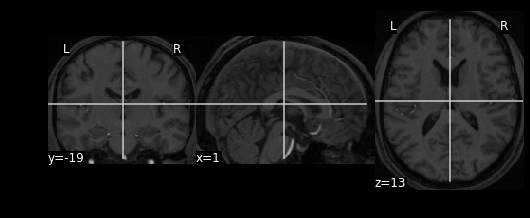

In [18]:
plot_anat(data)

Nilearn plotting functions are very flexible and allow us to easily customize our plots

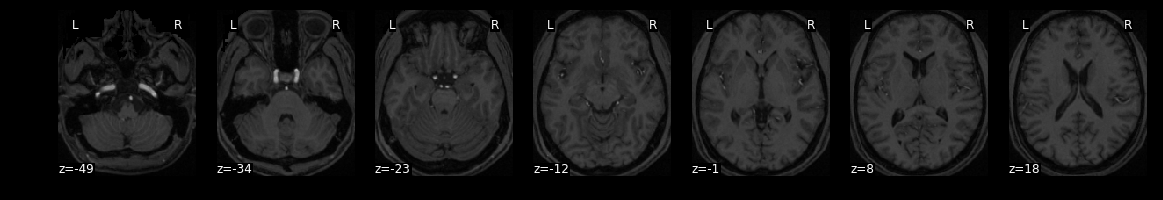

In [19]:
plot_anat(data, draw_cross=False, display_mode='z')

try to get more information how to use the function with `?` and try to add different commands to change the plot

nilearn also has a neat interactive viewer called `view_img` for examining images directly in the notebook. 

In [20]:
view_img(data)

The `view_img` function is particularly useful for overlaying statistical maps over an anatomical image so that we can interactively examine where the results are located.

As an example, let's load a mask of the amygdala and try to find where it is located.

In [25]:
amygdala_mask = nib.load(os.path.join(base_dir, 'resources', 'masks', 'FSL_BAmyg_thr0.nii.gz'))
view_img(amygdala_mask, data)

/Users/lukechang/anaconda3/lib/python3.7/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


We can also load 4D data such as a series of epi images.  Here we will load a short functional run from the same particiapnts.

In [27]:
epi = nib.load(os.path.join(base_dir, 'data', 'brainomics_data', 'S01', 'raw_fMRI_raw_bold.nii.gz'))
print(epi.shape)

(64, 64, 40, 1, 128)


For some reason nibabel is reading this nifti as a 5D image.  Let's quickly remove the extra dimension.

In [28]:
epi_data = epi.get_fdata()
epi_data = epi_data.squeeze()
print(epi_data.shape)

(64, 64, 40, 128)


Ok, looks like this fixed the dimensions.

Now, let's plot the average voxel signal intensity across the whole brain for each of the 128 TRs.

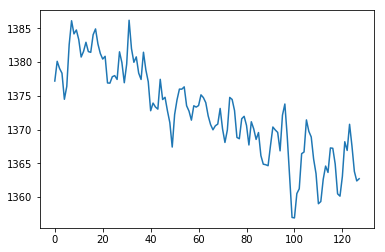

In [29]:
plt.plot(np.mean(epi_data,axis=(0,1,2)))

Notice the slow linear drift over time, where the global signal intensity gradually decreases.

# Brainiak

We highly recommend checking out [brainiak](https://brainiak.org/) another great python toolbox developed at Princeton in collaboration with Intel. They also have a number of tutorials for working with advanced data analyses.

# nltools

nltools is a python toolbox that makes it easy to work with neuroimaging data. It uses many functions from nilearn and other python libraries. The bulk of the nltools toolbox is built around the `Brain_Data()` class. The concept behind the class is to have a similar feel to a pandas dataframe, which means that it should feel intuitive to manipulate the data.

The `Brain_Data()` class has several attributes that may be helpful to know about. First, it stores imaging data in `.data` as a vectorized features by observations matrix. Each image is an observation and each voxel is a feature. Space is flattened using `nifti_masker` from nilearn. This object is also stored as an attribute in `.nifti_masker` to allow transformations from 2D to 4D matrices. In addition, a brain_mask is stored in `.mask`. Finally, there are attributes to store either class labels for prediction/classification analyses in `.Y` and design matrices in `.X`. These are both expected to be pandas `DataFrames`.

We will give a quick overview of basic Brain_Data operations, but we encourage you to see our [documentation](https://neurolearn.readthedocs.io/en/latest/index.html) for more details.

## Brain_Data Basics

To get a feel for `Brain_Data` let's load an example anatomical overlay image that comes packaged with the toolbox.

In [12]:
from nltools.data import Brain_Data
from nltools.utils import get_anatomical

a = Brain_Data(get_anatomical())

To view the attributes of `Brain_Data` use the `vars()` function.

In [13]:
print(vars(a))

{'mask': <nibabel.nifti1.Nifti1Image object at 0x1c1e2e3c88>, 'nifti_masker': NiftiMasker(detrend=False, dtype=None, high_pass=None, low_pass=None,
      mask_args=None,
      mask_img=<nibabel.nifti1.Nifti1Image object at 0x1c1e2e3c88>,
      mask_strategy='background', memory=Memory(location=None),
      memory_level=1, sample_mask=None, sessions=None, smoothing_fwhm=None,
      standardize=False, t_r=None, target_affine=None, target_shape=None,
      verbose=0), 'data': array([1875., 2127., 2182., ..., 5170., 5180., 2836.], dtype=float32), 'Y': Empty DataFrame
Columns: []
Index: [], 'X': Empty DataFrame
Columns: []
Index: [], 'file_name': []}


`Brain_Data` has many methods to help manipulate, plot, and analyze imaging data. We can use the `dir()` function to get a quick list of all of the available methods that can be used on this class.

To learn more about how to use these tools either use the `?` function, or look up the function in the [api documentation](https://neurolearn.readthedocs.io/en/latest/api.html).


In [14]:
print(dir(a))

['X', 'Y', '__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__rsub__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__weakref__', 'aggregate', 'align', 'append', 'apply_mask', 'astype', 'bootstrap', 'copy', 'data', 'decompose', 'detrend', 'distance', 'dtype', 'empty', 'extract_roi', 'file_name', 'filter', 'find_spikes', 'groupby', 'icc', 'iplot', 'isempty', 'mask', 'mean', 'multivariate_similarity', 'nifti_masker', 'plot', 'predict', 'predict_multi', 'r_to_z', 'regions', 'regress', 'scale', 'shape', 'similarity', 'smooth', 'standardize', 'std', 'sum', 'threshold', 'to_nifti', 'transform_pairwise', 'ttest', 'upload_neurovault', 'write']


Ok, now let's download a more interesting dataset from neurovault.

Here we fetch the pain dataset used in Chang et al., 2015 from neurovault. In this dataset there are 28 subjects with 3 separate beta images reflecting varying intensities of thermal pain (i.e., high, medium, low). The data will be downloaded to ~/nilearn_data, and automatically loaded as a Brain_Data() instance. The image metadata will be stored in data.X.

In [15]:
from nltools.datasets import fetch_pain

data = fetch_pain()

Here are a few quick basic data operations.

Find number of images in Brain_Data() instance

In [16]:
print(len(data))

84


Find the dimensions of the data (images x voxels)

In [17]:
print(data.shape())

(84, 238955)


We can use any type of indexing to slice the data such as integers, lists of integers, slices, or boolean vectors.

In [35]:
import numpy as np

print(data[5].shape())

print(data[[1,6,2]].shape())

print(data[0:10].shape())

index = np.zeros(len(data), dtype=bool)
index[[1,5,9, 16, 20, 22]] = True

print(data[index].shape())

(238955,)
(3, 238955)
(10, 238955)
(6, 238955)


Calculate the mean for every voxel over images

In [36]:
data.mean()

nltools.data.brain_data.Brain_Data(data=(238955,), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])

Calculate the standard deviation for every voxel over images

In [37]:
data.std()

nltools.data.brain_data.Brain_Data(data=(238955,), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])

Methods can be chained.  Here we get the shape of the mean.

In [40]:
print(data.mean().shape())

(238955,)


Brain_Data instances can be added and subtracted

In [42]:
new = data[1]+data[2]

Brain_Data instances can be manipulated with basic arithmetic operations.

Here we add 10 to every voxel and scale by 2

In [43]:
data2 = (data+10)*2


Brain_Data instances can be copied

In [44]:
new = data.copy()

Brain_Data instances can be easily converted to nibabel instances, which store the data in a 3D/4D matrix.  This is useful for interfacing with other python toolboxes such as [nilearn](http://nilearn.github.io)


In [45]:
data.to_nifti()

Brain_Data instances can be concatenated using the append method

In [47]:
new = new.append(data[4])

Lists of `Brain_Data` instances can also be concatenated by recasting as a `Brain_Data` object.

In [49]:
print(type([x for x in data]))

data = Brain_Data([x for x in data])

<class 'list'>


Any Brain_Data object can be written out to a nifti file.

In [ ]:
data.write('Tmp_Data.nii.gz')

Images within a Brain_Data() instance are iterable.  Here we use a list comprehension to calculate the overall mean across all voxels within an image.

In [50]:
[x.mean() for x in data]

[0.87218255,
 0.5573541,
 0.75735956,
 0.2633885,
 -0.058699485,
 0.09184363,
 -0.13793705,
 -0.5649727,
 -0.537673,
 0.24396032,
 0.073532216,
 0.011372491,
 0.30722636,
 -0.28306055,
 -0.18105659,
 0.08786721,
 0.057603072,
 0.021373956,
 -0.04227632,
 -0.13582082,
 -0.034632523,
 0.10422791,
 0.017766342,
 0.0068029333,
 0.35848427,
 0.041400384,
 0.20744492,
 0.36003327,
 0.027477775,
 -0.025727158,
 -0.11159037,
 -0.32340637,
 -0.21444643,
 0.3064718,
 -0.059435714,
 0.13685481,
 0.21339777,
 -0.21078208,
 -0.09267333,
 0.56659085,
 0.24975334,
 0.35955998,
 0.15065463,
 0.05305306,
 -0.065375164,
 0.8979233,
 0.34267116,
 0.4656757,
 0.13153507,
 -0.13321151,
 -0.009604877,
 0.048094068,
 -0.04076355,
 -0.091131374,
 0.11528444,
 -0.055009548,
 0.008810358,
 0.05496947,
 -0.028767614,
 0.0076631065,
 -0.06389547,
 -0.09988048,
 -0.06570268,
 -0.0071003204,
 -0.03190329,
 -0.032324836,
 0.022567509,
 -0.05973116,
 -0.07032426,
 0.33667368,
 0.079196304,
 0.25585917,
 0.19691963,
 

## Plotting
There are multiple ways to plot data.  

Brain_Data() instances can be converted to a nibabel instance and plotted using any plot method such as nilearn.

In addition, there is a fast axial montage `.plot()` function.

Finally, there is an interactive `.iplot()` method.

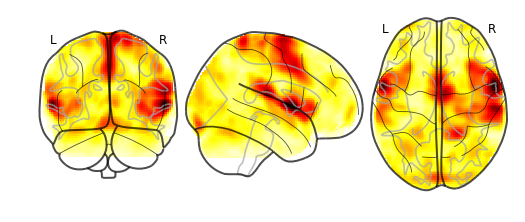

In [51]:
from nilearn.plotting import plot_glass_brain

plot_glass_brain(data.mean().to_nifti())

threshold is ignored for simple axial plots


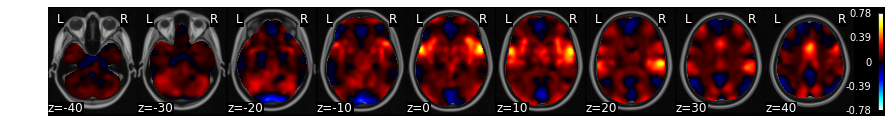

In [53]:
f = data.mean().plot()

In [54]:
data.mean().iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

Ok, that's the basics. `Brain_Data` can do much more!

Check out some of our [tutorials](https://neurolearn.readthedocs.io/en/latest/auto_examples/index.html) for more detailed examples.

We'll be using this tool throughout the course.